# Исследование данных, поиск полезных признаков и взаимосвязей, описание портрета недобросовестного поставщика

**Проект:** *Банковские гарантии*<br>
**История:** *Прогнозирование склонности попадания в РНП участника гос.закупок*<br>
**Этап:** *Портрет недобросовестного поставщика*<br>

* [Загрузка данных](#load)
* [Обзор данных](#review)
* [Анализ распределений признаков](#distr_analysis)
    * [Количественные признаки](#distr_analysis_num)
    * [Номинативные признаки](#distr_analysis_cat)
* [Поиск полезных взаимосвязей в признаках](#rels_analysis)
    * [Анализ линейных взаимосвязей](#rels_analysis_line)
* [Определение наиболее важных признаков, объясняющих целевую переменную](#imp_features)
* [Описание портрета недобросовестного поставщика](#portrait)

Голубин А.А., 21.03.2018

In [ ]:
import pandas as pd      
import numpy as np   

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.cluster import KMeans

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
dataset_path = '../intermediate_data/21_prepared_dataset.csv'

### Загрузка данных<a class="anchor" id="load"></a>

In [3]:
data = pd.read_csv(dataset_path, sep=';', encoding='utf-8')

### Обзор данных<a class="anchor" id="review"></a>

**Описание признаков**

Общая информация

* **Ogrn** - ОГРН 
* **OpfName** - организационно-правовая форма
* **RegionCode** - код региона
* **RegionName** - название региона
* **FederalDistrictName** - название федерального округа
* **OkvedCode** - код основого ОКВЭДа
* **OkvedName** - расшифровка основного ОКВЭДа
* **AuthorisedCapital** - размер уставного капитала (в рублях)
* **CompanyLifeTimeInMonths** - стаж компании (в месяцах)

Судебная информация

* **PlaintiffCount** - сколько раз компания выступала истцом
* **DefendentCount** - сколько раз компания выступала ответчиком
* **BailiffsCount** - сколько дел передано судебным приставам

Информация о государственных контрактах (общая)

* **PurchaseApplications** - количество заявок
* **WonContracts** - количество заключенных контрактов
* **FinishedContracts** - количество завершенных контрактов
* **MinContractSum** - минимальная сумма контракта
* **MaxContractSum** - максимальная сумма контракта 
* **AvgContractSum** - средняя сумма контракта
* **ContractCustomerCount** - количество уникальных заказчиков
* **MaxNumberOfContractsWithOneCustomer** - максимальное количество контрактов с одним заказчиком
* **ContractDurationAvg** - средний срок исполнения контракта

Информация о государственных контрактах (по последнему контракту)

* **ContractDurationLast** - срок исполнения последнего контракта
* **ContractObjectCodeLast** - код объекта закупки по последнему контракту
* **ContractObjectNameLast** - наименование объекта закупки по последнему контракту
* **CustomerOkvedCodeLast** - код ОКВЭДа заказчика по последнему контракту
* **CustomerOkvedNameLast** - расшифровка ОКВЭДа заказчика по последнему контракту
* **ContractsWithCustomerLast** - количество исполненных контрактов с заказчиком последнего контракта
* **OnProgressContractsWhileLast** - количество контрактов, находящихся в работе, параллельно с последним
* **ContractCustomerRegionCodeLast** - код региона заказчика по последнему контракту
* **ContractCustomerRegionNameLast** - название региона заказчика по последнему контракту
* **ContractCustomerFederalDistrictNameLast** - название федерального округа заказчика по последнему контракту

Информация о РНП

* **IsDishonest** - добросовестный / недобросоветсный поставщик (флаг)
* **DishonestReason** - описание причины попадания в РНП
* **DishonestReasonCode** - код причины попадания в РНП

In [12]:
data.iloc[100]

IsDishonest                                                                                1
Ogrn                                                                           1121831008859
OpfName                                             общество с ограниченной ответственностью
OpfGroup                                                                                 ооо
OkvedCode                                                                              46.73
OkvedName                                  торговля оптовая лесоматериалами, строительным...
RegionCode                                                                                18
RegionName                                                             Удмуртская Республика
FederalDistrictName                                                           Приволжский ФО
AuthorisedCapital                                                                      10000
CompanyLifeTimeInMonths                                               

In [13]:
data.dtypes 

IsDishonest                                  int64
Ogrn                                         int64
OpfName                                     object
OpfGroup                                    object
OkvedCode                                   object
OkvedName                                   object
RegionCode                                   int64
RegionName                                  object
FederalDistrictName                         object
AuthorisedCapital                          float64
CompanyLifeTimeInMonths                      int64
PurchaseApplications                       float64
WonContracts                               float64
FinishedContracts                          float64
MinContractSum                             float64
MaxContractSum                             float64
AvgContractSum                             float64
ContractCustomerCount                      float64
MaxNumberOfContractsWithOneCustomer        float64
ContractDurationAvg            

In [14]:
(len(data) - data.count()).sort_values(ascending=False)

DishonestReasonCode                        4130
DishonestReason                            4130
CustomerOkvedCodeLast                      1836
CustomerOkvedNameLast                      1836
ContractObjectNameLast                     1335
ContractObjectCodeLast                     1294
ContractCustomerRegionNameLast              568
ContractCustomerFederalDistrictNameLast     568
ContractCustomerRegionCodeLast              554
OkvedCode                                    98
OkvedName                                    98
FederalDistrictName                           0
CompanyLifeTimeInMonths                       0
AuthorisedCapital                             0
Ogrn                                          0
OpfGroup                                      0
RegionName                                    0
RegionCode                                    0
OpfName                                       0
WonContracts                                  0
PurchaseApplications                    

In [15]:
data.shape

(8061, 35)

In [6]:
data.IsDishonest.value_counts(normalize=True)

0    0.512343
1    0.487657
Name: IsDishonest, dtype: float64

**Приведение данных к подходящим типам**

In [16]:
data['Ogrn'] = data['Ogrn'].astype(str).values
data['RegionCode'] = data['RegionCode'].astype(str).values
data['ContractCustomerRegionCodeLast'] = data['ContractCustomerRegionCodeLast'].astype(str).values
data['DishonestReasonCode'] = data['DishonestReasonCode'].astype(str).values

### Анализ распределений признаков<a class="anchor" id="distr_analysis"></a>

**Выделение количественных и номинативных признаков**

In [17]:
data_numerical = data.select_dtypes(include=[np.number])
data_categorical = data[['IsDishonest', 'OpfName', 'OpfGroup', 'RegionName', 'FederalDistrictName', 'OkvedName', 
                         'CustomerOkvedNameLast', 'ContractObjectNameLast', 'ContractCustomerRegionNameLast',
                         'ContractCustomerFederalDistrictNameLast', 'DishonestReason']]

<a class="anchor" id="distr_analysis_num"></a>
**Количественные признаки**

Построим графики распределений каждого из количественных признаков, предварительно сгруппировав данные по присутствию в РНП

Распределение *зелёного* цвета - данные принадлежат *добросовестным* поставщикам<br>
Распределение *красного* цвета - данные принадлежат *недобросовестным* поставщикам

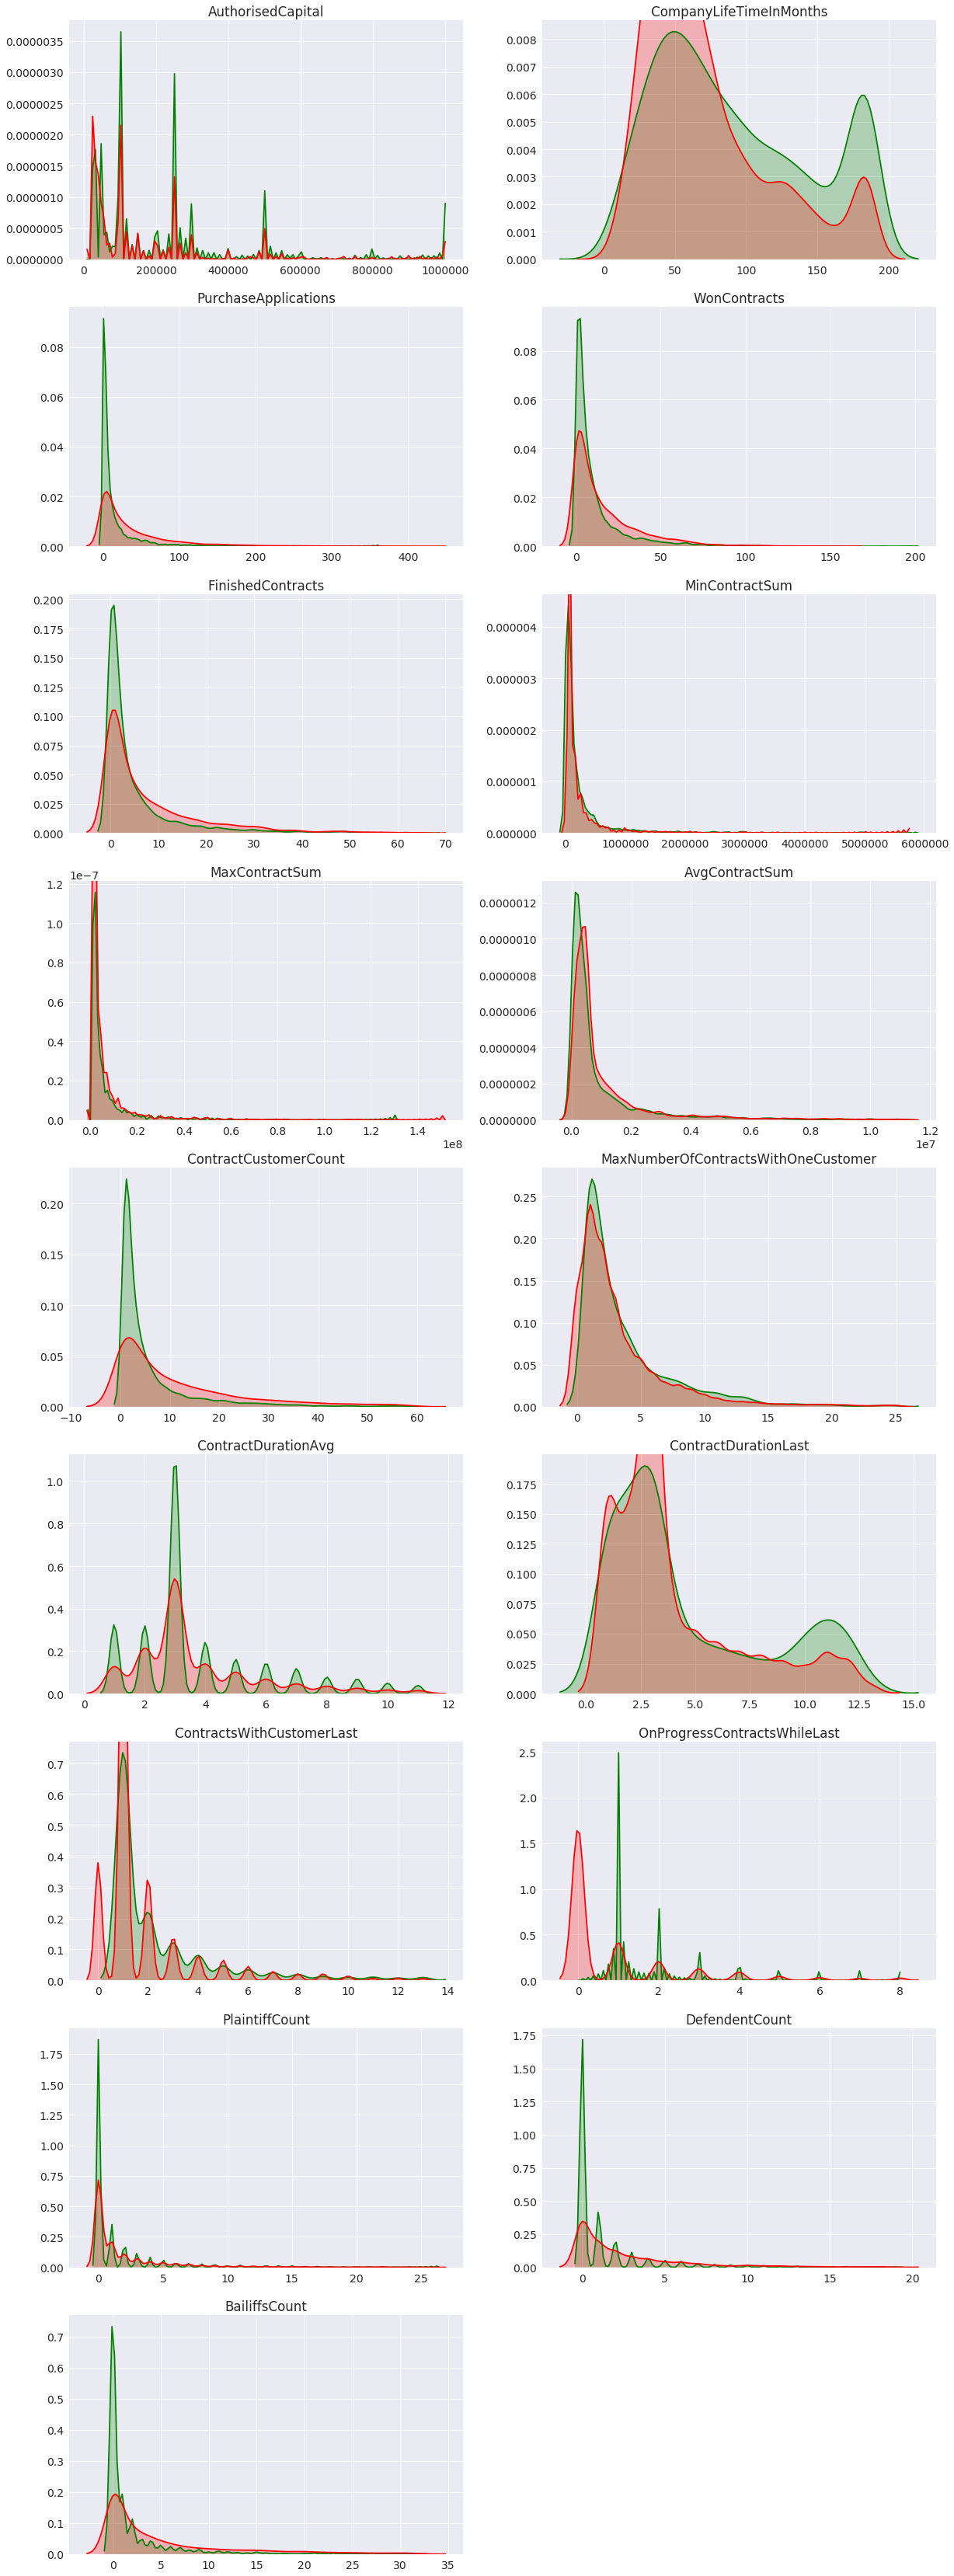

In [18]:
sns.set(font_scale=1.4)
plt.figure(figsize = (20,60))

for i, colname in enumerate(data_numerical.columns.drop('IsDishonest')):
    plt.subplot(9,2,i+1)
    plt.title(colname)
    sns.kdeplot(data_numerical.loc[data_numerical['IsDishonest'] == 0, colname], shade=True, legend=False, color='g')
    sns.kdeplot(data_numerical.loc[data_numerical['IsDishonest'] == 1, colname], shade=True, legend=False, color='r')
    
plt.show()

При визуальном анализе распределений количественных признаков в рамках целевой переменной (добросовестный/недобросовестный поставщик), можно выделить достаточно сильные различия в распределениях следующих признаков:
* CompanyLifeTimeInMonths - стаж компании (в месяцах)
* PurchaseApplications - количество заявок
* WonContracts - количество заключенных контрактов
* FinishedContracts - количество завершенных контрактов
* AvgContractSum - средняя сумма контракта
* ContractCustomerCount - количество уникальных заказчиков
* ContractDurationAvg - средний срок исполнения контракта
* ContractDurationLast - срок исполнения последнего контракта
* ContractsWithCustomerLast - количество исполненных контрактов с заказчиком последнего контракта
* OnProgressContractsWhileLast - количество контрактов, находящихся в работе, параллельно с последним
* PlaintiffCount - сколько раз компания выступала истцом
* DefendentCount - сколько раз компания выступала ответчиком
* BailiffsCount - сколько дел передано судебным приставам

Данные признаки могут стать наиболее полезными количественными предикторами для предсказания целевой переменной.

<a class="anchor" id="distr_analysis_cat"></a>
**Номинативные признаки**

1. Подсчитаем количество каждого значения для номинативных признаков.
2. Вычислим долю примеров являющихся недобросовестными поставщиками среди подсчитанных значений.
3. Отсортируем значения признаков в порядке убывания, как по общему количеству, так и по доле недобросовестных поставщиков.

In [19]:
for colname in data_categorical.columns.drop(['DishonestReason', 'IsDishonest']):
    print('*'*40 + colname + '*'*40, '\n')
    grouping = data_categorical.groupby(colname)

    stats = pd.DataFrame([grouping.size().index, 
                          grouping.size().values, 
                          (grouping['IsDishonest'].sum() / grouping.size()).values]).T
    stats.columns = ['feature_value', 'feature_count', 'badseller_coeff']
    print(stats.sort_values(['feature_count', 'badseller_coeff'], ascending=False).head(10), '\n'*5)

****************************************OpfName**************************************** 

                                        feature_value feature_count  \
27           общество с ограниченной ответственностью          7541   
21                   непубличное акционерное общество           120   
7   государственные бюджетные учреждения субъектов...            60   
0               автономные некоммерческие организации            45   
51                                 частные учреждения            39   
16                 муниципальные бюджетные учреждения            29   
19                муниципальные унитарные предприятия            27   
6   государственные автономные учреждения субъекто...            22   
45   федеральные государственные бюджетные учреждения            19   
35                     публичное акционерное общество            16   

   badseller_coeff  
27        0.509216  
21            0.35  
7        0.0166667  
0         0.244444  
51        0.128205  
16

Выборка значений номинативных признаков по которым наблюдается высокая доля (более 0.5) недобросовестных поставщиков, с учетом того, что количество примеров достаточно для статистического вывода (более 200).

**Признак:** *Название региона*

| Значение признака | Сколько раз встречается в выборке | Доля недобросовестных поставщиков |
|----------------------|------|----------|
|г. Москва             | 1416 | 0.587571 |
|Свердловская область  | 318  | 0.537736 |
|Новосибирская область | 265  | 0.532075 |
|Челябинская область   | 210  | 0.552381 |

**Признак:** *Название федерального округа*

| Значение признака | Сколько раз встречается в выборке | Доля недобросовестных поставщиков |
|---------------------|------|----------|
|Центральный ФО       | 2595 | 0.533719 |
|Приволжский ФО       | 1394 | 0.43472  |
|Сибирский ФО         | 1050 | 0.475238 |
|Северо-Западный ФО   | 982  | 0.431772 |
|Уральский ФО         | 821  | 0.54324  |
|Южный ФО             | 636  | 0.495283 |
|Дальневосточный ФО   | 397  | 0.433249 |
|Северо-Кавказский ФО | 186  | 0.451613 |

**Признак:** *Расшифровка основного ОКВЭДа*

| Значение признака | Сколько раз встречается в выборке | Доля недобросовестных поставщиков |
|--------------------------------------|------|----------|
|строительство жилых и нежилых зданий  | 1132 | 0.628092 |
|торговля оптовая неспециализированная | 355  | 0.574648 |

### Поиск полезных взаимосвязей в признаках<a class="anchor" id="rels_analysis"></a>

<a class="anchor" id="rels_analysis_line"></a>
**Анализ линейных взаимосвязей**

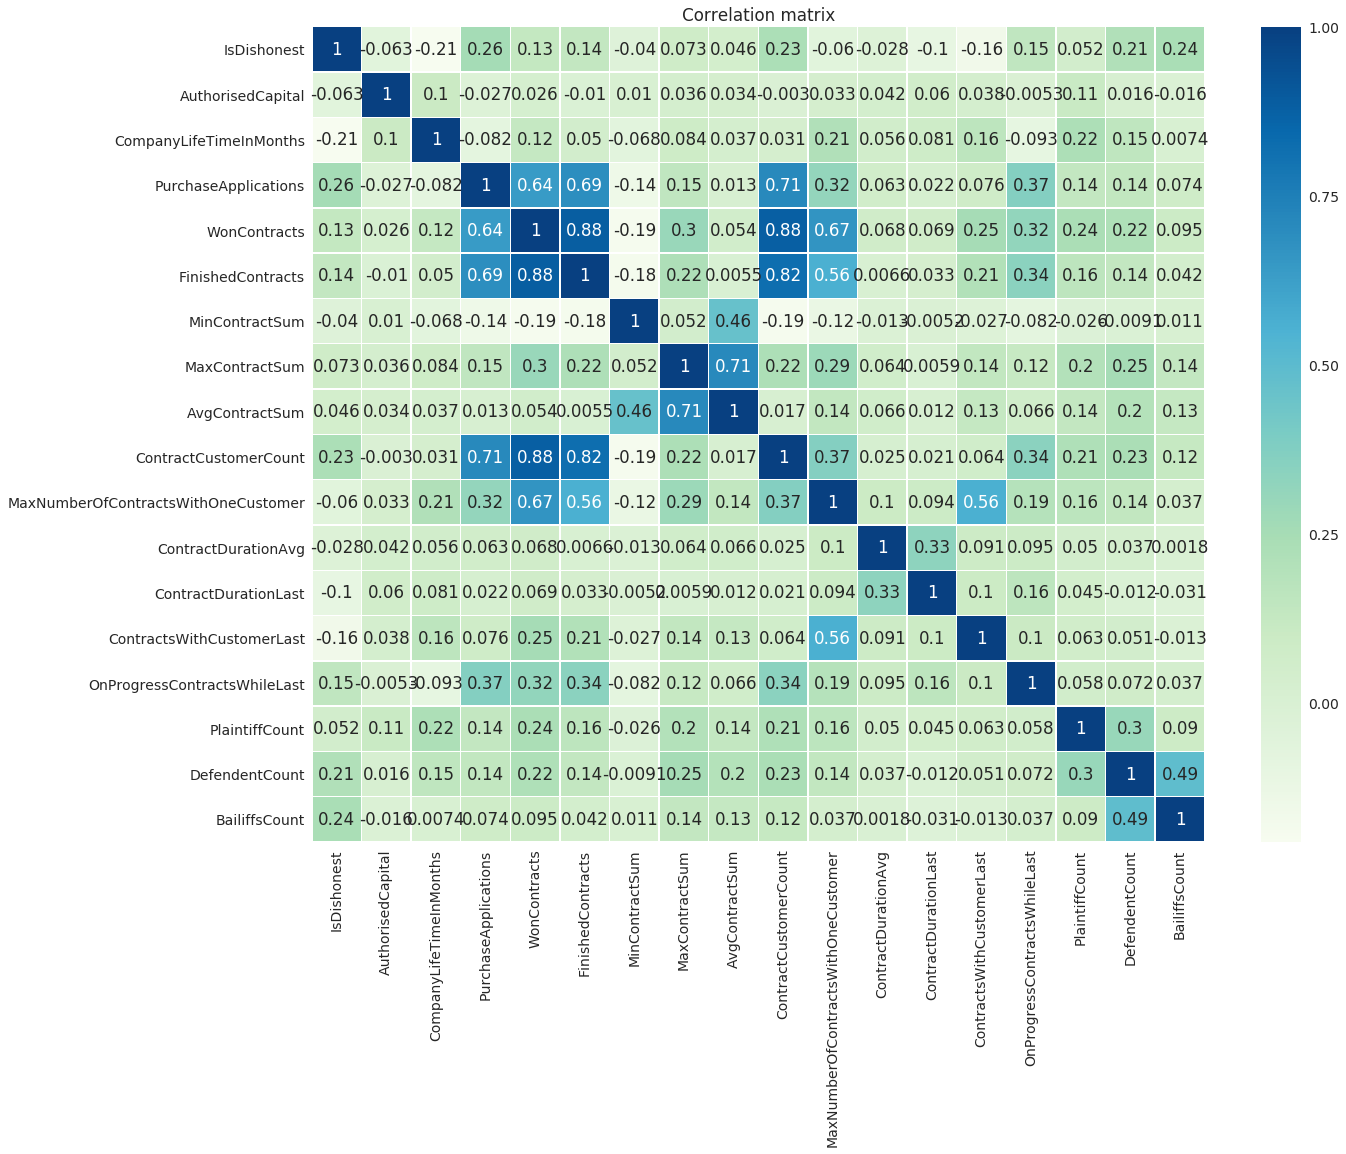

In [24]:
plt.figure(figsize = (20,15))

sns.set(font_scale=1.4)
sns.heatmap(data_numerical.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

*Наиболее сильные линейные зависимости между целевой переменной и предикторами:*

IsDishonest - CompanyLifeTimeInMonths, **-0.21**<br>
IsDishonest - PurchaseApplications, **0.26**<br>
IsDishonest - ContractCustomerCount, **0.23**<br>
IsDishonest - DefendentCount, **0.21**<br>
IsDishonest - BailiffsCount, **0.24**<br>

*Наиболее сильные линейные зависимости между предикторами:*

PurchaseApplications - WonContracts, **0.64**<br>
PurchaseApplications - FinishedContracts, **0.69**<br>
PurchaseApplications - ContractCustomerCount, **0.71**<br>
WonContracts - FinishedContracts, **0.88**<br>
WonContracts - ContractCustomerCount, **0.88**<br>
WonContracts - MaxNumberOfContractsWithOneCustomer, **0.67**<br>
FinishedContracts - ContractCustomerCount, **0.82**<br>
FinishedContracts - MaxNumberOfContractsWithOneCustomer, **0.56**<br>
MinContractSum - AvgContractSum, **0.46**<br>
MaxContractSum - AvgContractSum, **0.71**<br>
MaxNumberOfContractsWithOneCustomer - ContractsWithCustomerLast, **0.56**<br>
DefendentCount - BailiffsCount, **0.49**<br>

### Определение наиболее важных признаков, объясняющих целевую переменную<a class="anchor" id="imp_features"></a>

Планируется обучить классификаторы **LogisticRegression** и **XGBClassifier**, что бы посмотреть какие признаки они выделят, как обладающие наибольшей предсказательной силой

**Стандартизация количественных признаков**

In [211]:
X = data_numerical.drop('IsDishonest', axis=1)
y = data_numerical['IsDishonest']

scaler = preprocessing.StandardScaler()
scaler.fit(X)

X = pd.DataFrame(scaler.transform(X), columns=X.columns)
X = X.apply(round, ndigits=4)

**Добавление кодированных номинативных признаков**

In [201]:
# OpfGroup

opf_features = pd.get_dummies(data['OpfGroup'])
opf_features.rename(columns={'ао':'opf_ao', 
                             'гос':'opf_gos',
                             'ооо':'opf_ooo',
                             'прочие':'opf_other'}, inplace=True)

X = pd.concat([X, opf_features], axis=1)

# FederalDistrictName

feddistr_features = pd.get_dummies(data['FederalDistrictName'])
feddistr_features.rename(columns={'Дальневосточный ФО':'distr_vostok', 
                                  'Приволжский ФО':'distr_privolg',
                                  'Северо-Западный ФО':'distr_zapad',
                                  'Северо-Кавказский ФО':'distr_kavkaz',
                                  'Сибирский ФО':'distr_sibir',
                                  'Уральский ФО':'distr_ural',
                                  'Центральный ФО':'distr_center',
                                  'Южный ФО':'distr_ug'
                                 }, inplace=True)

X = pd.concat([X, feddistr_features], axis=1)

**Разбиение на train / test**

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=17)

**LogisticRegression**

In [213]:
logit = LogisticRegression()
logit.fit(X_train, y_train)

print('TRAIN\n\n' + classification_report(y_train, logit.predict(X_train)))
print('TEST\n\n' + classification_report(y_test, logit.predict(X_test)))
print('CONFUSION MATRIX\n')
print(pd.crosstab(y_test, logit.predict(X_test)))

TRAIN

             precision    recall  f1-score   support

          0       0.70      0.77      0.73      2762
          1       0.73      0.65      0.69      2638

avg / total       0.71      0.71      0.71      5400

TEST

             precision    recall  f1-score   support

          0       0.70      0.78      0.74      1368
          1       0.74      0.65      0.69      1293

avg / total       0.72      0.72      0.71      2661

CONFUSION MATRIX

col_0           0    1
IsDishonest           
0            1070  298
1             459  834


In [214]:
coeff_list = ([logit.intercept_[0]])
coeff_list.extend(logit.coef_[0])

logit_coeffs_df = pd.DataFrame({'feature_name': ['Intercept'] + list(X.columns), 'coeff': coeff_list})
logit_coeffs_df.sort_values('coeff', ascending=False)

,coeff,feature_name
3,0.726861,PurchaseApplications
17,0.422716,BailiffsCount
16,0.320726,DefendentCount
9,0.230281,ContractCustomerCount
8,0.190352,AvgContractSum
14,0.164450,OnProgressContractsWhileLast
15,0.050434,PlaintiffCount
0,0.010501,Intercept
4,-0.010082,WonContracts
11,-0.026695,ContractDurationAvg


**XGBClassifier**

In [215]:
xgbc = XGBClassifier(colsample_bytree=0.5)
xgbc.fit(X_train, y_train)

print('TRAIN\n\n' + classification_report(y_train, xgbc.predict(X_train)))
print('TEST\n\n' + classification_report(y_test, xgbc.predict(X_test)))
print('CONFUSION MATRIX\n')
print(pd.crosstab(y_test, xgbc.predict(X_test)))

TRAIN

             precision    recall  f1-score   support

          0       0.81      0.85      0.83      2762
          1       0.83      0.80      0.81      2638

avg / total       0.82      0.82      0.82      5400

TEST

             precision    recall  f1-score   support

          0       0.78      0.83      0.80      1368
          1       0.81      0.75      0.78      1293

avg / total       0.79      0.79      0.79      2661

CONFUSION MATRIX

col_0           0    1
IsDishonest           
0            1138  230
1             325  968


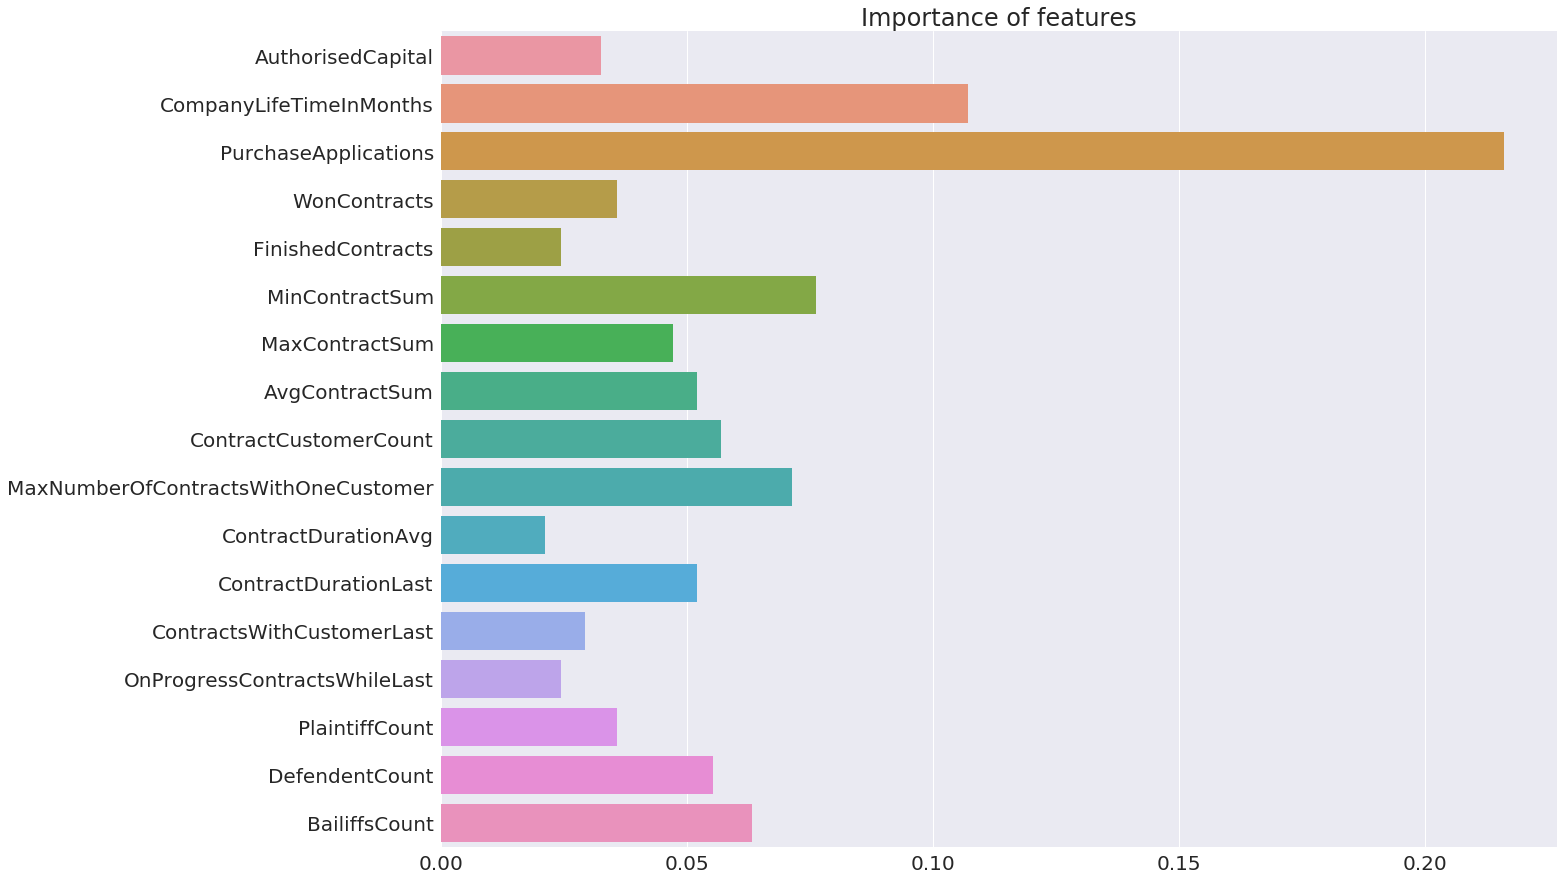

In [216]:
plt.figure(figsize = (20,15))

sns.set(font_scale=2)
sns.barplot(xgbc.feature_importances_, X_test.columns)

plt.title('Importance of features')
plt.show()  

**Наиболее важные признаки, которые влияют (напрямую или косвенно) на склонность попадания в РНП:**

* Признаки, влияющие на склонность положительно (чем больше значение признака, тем склонность выше)
    * Общее количество заявок, поданных компанией на участие в гос. контрактах
    * Сколько дел, относительно компании, передано судебным приставам
    * Сколько раз компания выступала ответчиком
    * Количество уникальных заказчиков


* Признаки, влияющие на склонность отрицательное (чем больше значение признака, тем склонность ниже)    
    * Период существования компании (в месяцах)
    * Количество уже исполненных контрактов, с заказчиком последнего контракта
    * Время исполнения последнего контракта (в месяцах)
    
\* *признаки расположены в порядке убывания степени влияния*

### Описание портрета недобросовестного поставщика<a class="anchor" id="portrait"></a>

**По сроку существования компании:**
* компании с относительно небольших сроком существования

**По виду деятельности:**
* строительство жилых и нежилых зданий
* торговля оптовая неспециализированная

**По региону присутствия:**
* г. Москва
* Свердловская область
* Новосибирская область
* Челябинская область

**По истории участия в гос. закупках:**
* количество поданных заявок на участие превышает среднее значение для схожих организаций
* большое количество разных (уникальных) заказчиков

**По судебной истории организации:**
* компании часто выступающие ответчиком в суде и, как следствие, на которых заведено много дел судебными приставами

In [7]:
import sys

sys.path.append('/home/ibpmuser/jupyter-notebooks/DSK/MasterFolder/MasterCode/')

from smtp_email import Email

In [8]:
em = Email('hadoop2')

em.set_email_meta('Тетрадка с результатами', 
                  'Банковские гарантии', 
                  email_attachments=['./#22_data_exploration_and_report.ipynb', dataset_path])

em.send_email('rustem.galiullin@akbarsdigital.ru')